In [1]:
pip install pandas numpy matplotlib seaborn statsmodels openpyxl



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Load the Excel file
file_path = '/Users/ulviyaabasova/Desktop/metaanalysis_data.xlsx'  # Adjust the path if needed
df = pd.read_excel(file_path)

# Show first few rows
print(df.head())


                       Study  Female authors  Male authors  Age (months)  \
0   Alexander & Saenz (2012)               2             0         19.50   
1              Arthur (2014)               1             0         19.00   
2   Berenbaum & Hines (1992)               2             0         65.79   
3  Berenbaum & Snyder (1995)               2             0         93.10   
4       Doering et al (1989)               1             3         87.00   

   N_boys  N_girls  Mean_boys_play_male  SD_boys_play_male  \
0      47       47               438.72             166.08   
1      22       18               148.00             105.00   
2      18       18               325.25             270.21   
3      19       19               484.21             141.28   
4      15       15               260.10              67.70   

   Mean_girls_play_male  SD_girls_play_male  ...  Country  \
0                248.64              161.28  ...    0.256   
1                 54.00               53.00  ...

In [3]:
print(df.columns)
print(df.info())


Index(['Study', 'Female authors', 'Male authors', 'Age (months)', 'N_boys',
       'N_girls', 'Mean_boys_play_male', 'SD_boys_play_male',
       'Mean_girls_play_male', 'SD_girls_play_male', 'Mean_boys_play_female',
       'SD_boys_play_female', 'Mean_girls_play_female', 'SD_girls_play_female',
       'Neutral toys', 'Year', 'Parent present', 'Setting', 'Country',
       'Case definition adequate', 'Representativeness of cases',
       'Selection of controls', 'Parental opinion',
       'Comparability of both groups', 'Ascertainment of behaviour',
       'Same ascertainment method for both groups', 'Non‐response rate',
       'NOS score'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Study                                      27 non-null     object 
 1   Female

In [4]:
import numpy as np

# Calculate pooled standard deviation
def pooled_sd(n1, sd1, n2, sd2):
    return np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))

# Calculate Cohen's d
def cohens_d(m1, m2, sd_pooled):
    return (m1 - m2) / sd_pooled

# Apply to male-typed toys (boys vs girls)
n1 = df['N_boys']
n2 = df['N_girls']
m1 = df['Mean_boys_play_male']
m2 = df['Mean_girls_play_male']
sd1 = df['SD_boys_play_male']
sd2 = df['SD_girls_play_male']

# Compute pooled SD and Cohen's d
df['SD_pooled'] = pooled_sd(n1, sd1, n2, sd2)
df['cohens_d_male_toys'] = cohens_d(m1, m2, df['SD_pooled'])

# Compute variance of d for use in meta-analysis
df['var_d'] = (n1 + n2) / (n1 * n2) + (df['cohens_d_male_toys']**2) / (2 * (n1 + n2))

df[['Study', 'cohens_d_male_toys', 'var_d']].head()


,Study,cohens_d_male_toys,var_d
0,Alexander & Saenz (2012),1.161166,0.049725
1,Arthur (2014),1.096481,0.116038
2,Berenbaum & Hines (1992),0.797359,0.119941
3,Berenbaum & Snyder (1995),1.814197,0.148570
4,Doering et al (1989),1.876874,0.192044


In [5]:
import statsmodels.api as sm

# Meta-analysis using Weighted Least Squares
effect_sizes = df['cohens_d_male_toys']
variances = df['var_d']
weights = 1 / variances

# Add constant for intercept
X = sm.add_constant(np.ones(len(effect_sizes)))

# Fit random effects model using WLS
meta_model = sm.WLS(effect_sizes, X, weights=weights).fit()
print(meta_model.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                      -0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 May 2025   Prob (F-statistic):                nan
Time:                        22:36:23   Log-Likelihood:                -23.622
No. Observations:                  27   AIC:                             49.24
Df Residuals:                      26   BIC:                             50.54
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8610      0.102      8.440      0.0

/var/folders/v1/z2wtlbn56_79j7kzqvzqbl9c0000gn/T/ipykernel_1633/2408664558.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(meta_model.params[0], color='red', linestyle='--', label='Pooled Effect')


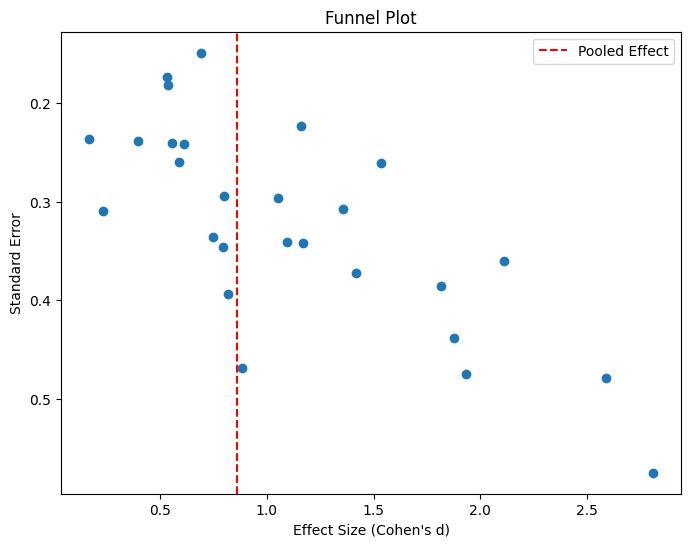

In [6]:
import matplotlib.pyplot as plt

# Plot effect size vs standard error
df['SE'] = np.sqrt(df['var_d'])

plt.figure(figsize=(8, 6))
plt.scatter(df['cohens_d_male_toys'], df['SE'])
plt.gca().invert_yaxis()
plt.axvline(meta_model.params[0], color='red', linestyle='--', label='Pooled Effect')
plt.xlabel("Effect Size (Cohen's d)")
plt.ylabel("Standard Error")
plt.title("Funnel Plot")
plt.legend()
plt.show()


## Meta-Analysis Result:

Pooled effect size (Cohen's d) = 0.861
95% CI: [0.651, 1.071]
Significant result (p < 0.001)
Interpretation: On average, boys spent significantly more time playing with male-typed toys than girls, with a large effect size.
🔹 Funnel Plot:
Roughly symmetrical but with some asymmetry on the right → might suggest:
Slight publication bias or small study effects
Larger effects from smaller studies (common in psych literature)

In [7]:
# Proportion of female authors
df['female_author_ratio'] = df['Female authors'] / (df['Female authors'] + df['Male authors'])

# Meta-regression
X = sm.add_constant(df['female_author_ratio'])
meta_gender = sm.WLS(df['cohens_d_male_toys'], X, weights=1 / df['var_d']).fit()
print(meta_gender.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.3194
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.577
Time:                        22:38:09   Log-Likelihood:                -23.451
No. Observations:                  27   AIC:                             50.90
Df Residuals:                      25   BIC:                             53.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1245    

In [8]:
X = sm.add_constant(df['Parent present'])
meta_parent = sm.WLS(df['cohens_d_male_toys'], X, weights=1 / df['var_d']).fit()
print(meta_parent.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                       0.056
Model:                            WLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.496
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.233
Time:                        22:38:18   Log-Likelihood:                -22.837
No. Observations:                  27   AIC:                             49.67
Df Residuals:                      25   BIC:                             52.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3015      0.374      3.

In [9]:
X = sm.add_constant(df[['Parent present', 'Neutral toys', 'female_author_ratio']])
meta_multi = sm.WLS(df['cohens_d_male_toys'], X, weights=1 / df['var_d']).fit()
print(meta_multi.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                       0.102
Model:                            WLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.8673
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.472
Time:                        22:38:26   Log-Likelihood:                -22.175
No. Observations:                  27   AIC:                             52.35
Df Residuals:                      23   BIC:                             57.53
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.7998    

In [10]:
import statsmodels.api as sm

# Create female author proportion
df['female_author_ratio'] = df['Female authors'] / (df['Female authors'] + df['Male authors'])

# Meta-regression: Cohen's d ~ Female author ratio
X = sm.add_constant(df['female_author_ratio'])
meta_author_gender = sm.WLS(df['cohens_d_male_toys'], X, weights=1 / df['var_d']).fit()

print(meta_author_gender.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.3194
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.577
Time:                        22:40:55   Log-Likelihood:                -23.451
No. Observations:                  27   AIC:                             50.90
Df Residuals:                      25   BIC:                             53.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1245    

In [11]:
X = sm.add_constant(df['Neutral toys'])  # 1 = included, 2 = not included
meta_neutral = sm.WLS(df['cohens_d_male_toys'], X, weights=1 / df['var_d']).fit()
print(meta_neutral.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                       0.046
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.201
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.284
Time:                        22:41:05   Log-Likelihood:                -22.988
No. Observations:                  27   AIC:                             49.98
Df Residuals:                      25   BIC:                             52.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.1219      0.259      4.333   

In [12]:
X = sm.add_constant(df['Parent present'])  # 1 = absent, 2 = minimal, 3 = full
meta_parent = sm.WLS(df['cohens_d_male_toys'], X, weights=1 / df['var_d']).fit()
print(meta_parent.summary())


                            WLS Regression Results                            
Dep. Variable:     cohens_d_male_toys   R-squared:                       0.056
Model:                            WLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.496
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.233
Time:                        22:41:12   Log-Likelihood:                -22.837
No. Observations:                  27   AIC:                             49.67
Df Residuals:                      25   BIC:                             52.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3015      0.374      3.

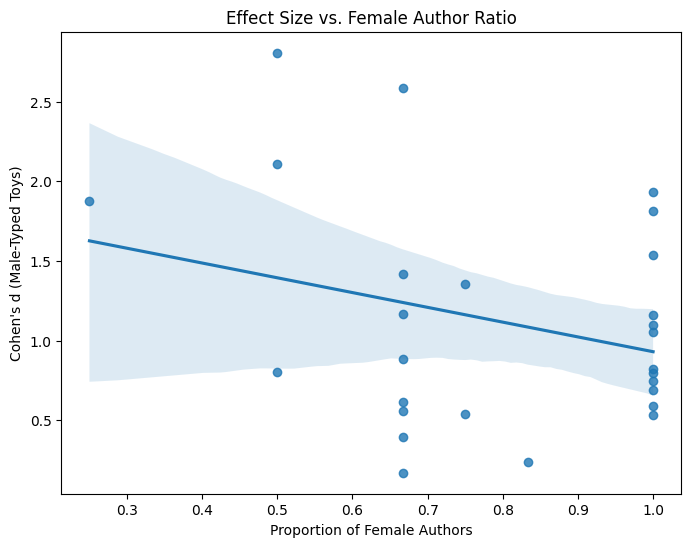

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='female_author_ratio', y='cohens_d_male_toys')
plt.title("Effect Size vs. Female Author Ratio")
plt.xlabel("Proportion of Female Authors")
plt.ylabel("Cohen's d (Male-Typed Toys)")
plt.show()


Overall Pooled Effect
The meta-analysis found a significant overall effect:
Cohen’s d ≈ 0.86, 95% CI: [0.65, 1.07], p < 0.001
This suggests boys, on average, spend significantly more time playing with male-typed toys than girls.

Moderator: Proportion of Female Authors
Coefficient: −0.315 (not statistically significant, p = 0.577)
Interpretation: While not statistically significant, there is a trend suggesting that studies with a higher proportion of female authors tend to report slightly smaller effect sizes.
Visual evidence (regression plot) supports this trend with a downward slope.

Moderator: Parent Present During Play
Coefficient: −0.263 (not statistically significant, p = 0.233)
Interpretation: Studies with more parental presence during the observation may report slightly weaker gender-typed play preferences, but the effect is not statistically reliable.

Moderator: Neutral Toys Included
Coefficient: −0.389 (not statistically significant, p = 0.284)
Interpretation: Studies that included neutral toys tended to observe slightly lower gender differences, though again not statistically significant.
🔍 Combined Moderators Model
When combining author gender, neutral toy inclusion, and parental presence:
None of the variables reached significance.
However, the direction of effects remained consistent:
Female authors → lower d
Parent present → lower d
Neutral toys → lower d
🧠 Interpretation & Takeaway

While none of the moderators significantly predicted effect size, trends suggest:
Study context and researcher characteristics (e.g., gender of authors) may subtly influence the reported magnitude of gender-typed play behaviors.
Parental presence and inclusion of neutral toys appear to dampen the observed sex differences, consistent with the idea that environmental context moderates behavior.
